In [2]:
import warnings

import numpy as np
import pandas as pd
from math import isclose
from scipy import stats
import matplotlib
import copy
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
def calc_perprof(df, problem_def, perf_meas, solver_char, inv_perf_meas=False, tau_val=None):
    data = df.sort_values(by=problem_def + solver_char).copy()

    if not all(isinstance(l, list) for l in [problem_def, perf_meas, solver_char]):
        raise TypeError('`problem_def`, `perf_meas`, and `solver_char` should'
                        'be lists')

    if len(solver_char) > 1:
        # Merging columns if one than one solver characteristic is selected
        new_solver_nm = ''
        for n, m in enumerate(solver_char):
            if n == 0:
                new_solver_nm += data['{}'.format(solver_char[n])].map(str)
            else:
                new_solver_nm += '_' + data['{}'.format(solver_char[n])].map(str)
        
        data['{}'.format(solver_char[0])] = new_solver_nm

    if len(set(solver_char) & set(problem_def)) != 0:
        # Checking if problem definition and solver characteristic are unique
        raise ValueError('Solver characteristic and problem definition share characteristic: ',
                         list(set(solver_char) & set(problem_def)))

    # Finding the unique solvers
    solvers = data[solver_char[0]].unique()

    # Generating df containing all unique problems
    grouped_by_problem = data.groupby(problem_def)
    
    # dividing by the minimum value
    for i, (prob, gr) in enumerate(grouped_by_problem):
        # Checking if all problems have an equal number of solvers
        if i == 0:
            gr_len = len(gr)

        if gr_len != len(gr):
            raise ValueError('Problem group lengths not equal! Problem gr:', prob)

        try:
            # Normalizing and penalizing infeasible designs
            # If feasibility is satisfied, the performance measure is compared to
            # the minimum value among all methods that are feasible.

            # If feasibility is not satisfied, the maximum occuring value among
            # all solvers is allocated and a small value is added.
            # This value is added to be able to differentiate between the solvers
            # that terminated with the maximum value that are feasible from
            # the solvers that did not return a feasible point
            true_min = gr.loc[gr['feas'] == True][perf_meas].min()[0]
            if inv_perf_meas == False:
                data.at[gr.loc[gr['feas'] == True].index, perf_meas] = gr[perf_meas] / true_min
                data.at[gr.loc[gr['feas'] == False].index, perf_meas] = gr[perf_meas].max()[0] / true_min + .05
            else:
                if i == 0:
                    warnings.warn('Performance ratio calculated using inverse.')
                data.at[gr.loc[gr['feas'] == True].index, perf_meas] = true_min / gr[perf_meas]
                data.at[gr.loc[gr['feas'] == False].index, perf_meas] = true_min / gr[perf_meas].max()[0] + .05

        except KeyError:
            if not inv_perf_meas:
                data.at[gr.index, perf_meas]= gr[perf_meas] / gr[perf_meas].min()[0]
            else:
                if i == 0:
                    warnings.warn('Performance ratio calculated using inverse.')
                data.at[gr.index, perf_meas] = gr[perf_meas].min()[0] / gr[perf_meas]

    # Generate array for plot
    if (df[perf_meas[0]] < 0).any():
        warnings.warn('Negative objective function value detected, this may '
                      'cause unwanted scaling of problems.')

    if (len(data) // len(solvers)) != len(grouped_by_problem):
        warnings.warn('Combination of problem and solver characteristic '
                      'cause, possibly unwanted, aggregation of problems.')

    # Grouping by unique solver
    grouped_by_solver = data.groupby(solver_char)

    if tau_val == None:
        # Finding the unique tau values
        unique_taus = np.sort(data[perf_meas[0]].unique())
    else:
        # Using the user generated tau values
        unique_taus = tau_val

    # Finding the fraction of problems that each solver solved within tau
    solver_taus = np.zeros((len(grouped_by_solver), len(unique_taus)))
    for n, tau in enumerate(unique_taus):
        for i, (_, gr) in enumerate(grouped_by_solver):
            if i == 0 and n == 0:
                print('Number of problems per solver: ', len(gr))
            solver_taus[i, n] = len(gr.loc[gr[perf_meas[0]] <= tau]) / len(grouped_by_problem)
            
    if not isclose(solver_taus[:, 0].sum(), 1, rel_tol=1e-3):
        warnings.warn('Solvers do not solve 100% of problems. '
                      'Total amount of problems solved: {}'.format(100 * solver_taus[:, 0].sum()))

    return unique_taus, solver_taus, solvers, data


In [4]:
problems = pd.Series(['CIFAR', 'Spherical', 'Ninapro', 'FSD50k', 'DarcyFlow', 'Protein', 'Cosmic', 'ECG', 'Satellite', 'Deepsea'], dtype=str, name='problem')
methods = pd.Series(['WRN', 'DenseNAS', 'DenseNAS-RS'], dtype=str, name='method')
fast_problems = (problems.append(problems)).append(problems)
fast_methods = methods.repeat(10)
objective_vals = pd.Series([23.35, 85.77, 6.78, 92.43, 7.27, 3.84, 24.5, 43.17, 15.49, 39.67,], name='obj')
densenas = np.array([100]*10) - np.array([74.02, 27.01, 89.83, 35.63, 90.03, 96.16, 61.702, 59.77, 86.19, 59.55])
densenas_rs = np.array([100]*10) - np.array([74.51, 28.77, 91.55, 40.13, 92.93, 96.3, 69.0433, 57.93, 86.09, 59.7])
objective_vals=objective_vals.append(pd.Series(densenas))
objective_vals=objective_vals.append(pd.Series(densenas_rs))
fast_methods = fast_methods.reset_index(drop=True)
fast_problems = fast_problems.reset_index(drop=True)
objective_vals = objective_vals.reset_index(drop=True)
fast_df = pd.DataFrame([fast_problems, fast_methods, objective_vals]).T
fast_df.columns = ['problem', 'method', 'obj']
slow_problems = problems.append(problems)
slow_methods = pd.Series(['Tuned WRN', 'GAEA PC-DARTS'], dtype=str, name='method')
slow_methods = slow_methods.repeat(10)
tuned_wrn = np.array([100]*10) - np.array([76.61, 24.54, 92.66, 9.37, 93.4, 96.16, 74.939, 56.7, 84.16, 59.3])
gaea = np.array([100]*10- np.array([75.98, 51.76, 82.33, 6.1, 97.4, 97.05, 77.026, 66, 87.49, 64]))
slow_vals = pd.Series(tuned_wrn).append(pd.Series(gaea))

slow_problems = slow_problems.reset_index(drop=True)
slow_methods = slow_methods.reset_index(drop=True)
slow_vals = slow_vals.reset_index(drop=True)

slow_df = pd.DataFrame([slow_problems, slow_methods, slow_vals]).T
slow_df.columns = ['problem', 'method', 'obj']

all_df = pd.concat([slow_df, fast_df])
all_df = all_df.reset_index(drop=True)


all_taus, all_solver_vals, all_solvers, all_transformed_data = calc_perprof(all_df, ['problem'], ['obj'], ['method'])


Number of problems per solver:  10


/tmp/ipykernel_1669375/1516532966.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fast_problems = (problems.append(problems)).append(problems)
/tmp/ipykernel_1669375/1516532966.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  objective_vals=objective_vals.append(pd.Series(densenas))
/tmp/ipykernel_1669375/1516532966.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  objective_vals=objective_vals.append(pd.Series(densenas_rs))
/tmp/ipykernel_1669375/1516532966.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slow_problems = problems.append(problems)
/tmp/ipykernel_1669375/1516532966.py:20: FutureWarning: The series.append

/tmp/ipykernel_1669375/419512027.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)


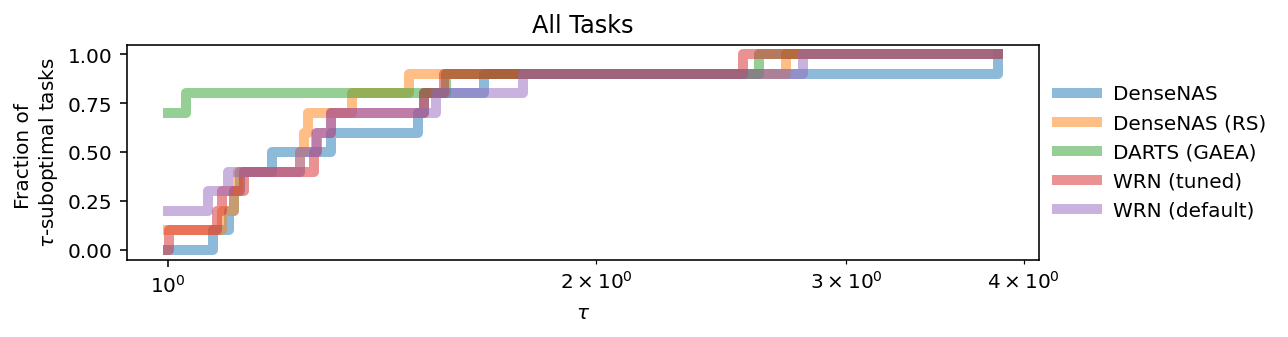

In [5]:
def draw_simple_pp(taus, solver_vals, solvers):
    """Simple step plotter for performance profiles.
    Parameters
    ----------
    taus : numpy.ndarray
        x values of plot.
    solver_vals : numpy.ndarray
        y values of plot.
    solvers : list
        Labels of curves.
    """
    
    fig = plt.figure(figsize=(9.0, 2.5))
    ax = fig.add_subplot(111)
    
    # Add lines individually to support labels
    for n, solver in enumerate(solvers):
        if solver == 'GAEA PC-DARTS':
            solver = 'DARTS (GAEA)'
        elif solver == 'Tuned WRN':
            solver = 'WRN (tuned)'
        elif solver == 'WRN':
            solver = 'WRN (default)'
        elif solver == 'DenseNAS-RS':
            solver = 'DenseNAS (RS)'
        ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)
        
    plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('Fraction of \n' + r'$\tau$-suboptimal tasks')
    #ax.yaxis.label.set_size(18)
    #ax.xaxis.label.set_size(18)
    
    # TODO
    ax.set_xscale('log')


    #ax.set_yscale('log')
    #plt.xlim(1, taus.max())
    #plt.xticks([1e0, 2e0, 3e0])
    ax.set_title('All Tasks')
    #ax.title.set_size(20)
    #ax.tick_params(axis='both', which='minor', labelsize=16)
    #plt.minorticks_off()

    plt.tight_layout()
    plt.savefig('pp_10.pdf')

draw_simple_pp(all_taus, all_solver_vals, all_solvers)

Number of problems per solver:  4


/tmp/ipykernel_1669375/2807478945.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)


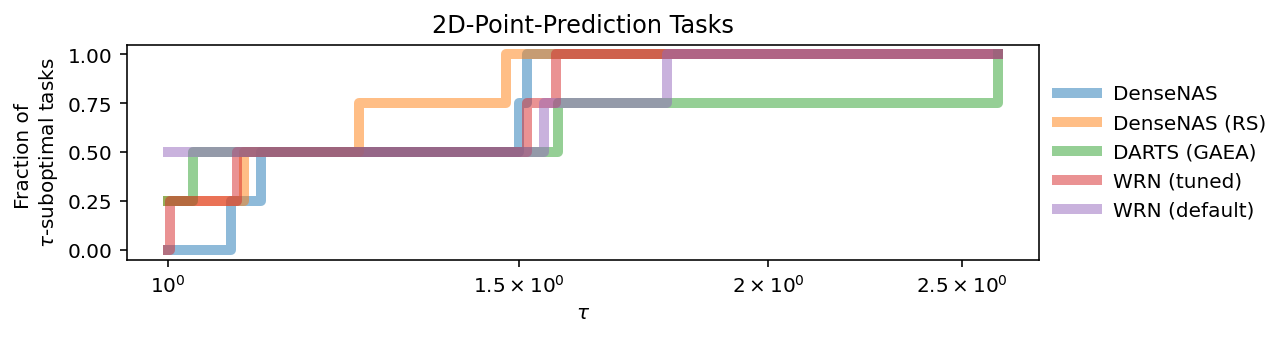

In [6]:
def draw_small_pp(taus, solver_vals, solvers):
    """Simple step plotter for performance profiles.
    Parameters
    ----------
    taus : numpy.ndarray
        x values of plot.
    solver_vals : numpy.ndarray
        y values of plot.
    solvers : list
        Labels of curves.
    """
    
    fig = plt.figure(figsize=(9.0, 2.5))
    ax = fig.add_subplot(111)
    
    # Add lines individually to support labels
    for n, solver in enumerate(solvers):
        if solver == 'GAEA PC-DARTS':
            solver = 'DARTS (GAEA)'
        elif solver == 'Tuned WRN':
            solver = 'WRN (tuned)'
        elif solver == 'WRN':
            solver = 'WRN (default)'
        elif solver == 'DenseNAS-RS':
            solver = 'DenseNAS (RS)'
        ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)
        
    plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('Fraction of \n' + r'$\tau$-suboptimal tasks')
    #ax.yaxis.label.set_size(18)
    #ax.xaxis.label.set_size(18)
    
    ax.set_xscale('log')

    #ax.set_yscale('log')
    #plt.xlim(1, 2)
    plt.xticks([1e0, 1.5e0, 2e0, 2.5e0])
    ax.set_title('2D-Point-Prediction Tasks')
    #ax.title.set_size(20)
    ax.tick_params(axis='both', which='minor')
    plt.minorticks_off()
    #ax.set_xticks([0,1,2])
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.get_xaxis().get_major_formatter().labelOnlyBase = False

    plt.tight_layout()
    plt.savefig('pp_4.pdf')

point_pred = ['CIFAR', 'Spherical', 'Ninapro', 'FSD50k']
df_point_pred = all_df[all_df['problem'].isin(point_pred)]
df_point_pred = df_point_pred.reset_index(drop=True)
point_taus, point_solver_vals, point_solvers, point_transformed_data = calc_perprof(df_point_pred, ['problem'], ['obj'], ['method'])

draw_small_pp(point_taus, point_solver_vals, point_solvers)

Number of problems per solver:  10


/tmp/ipykernel_1669375/462547439.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)


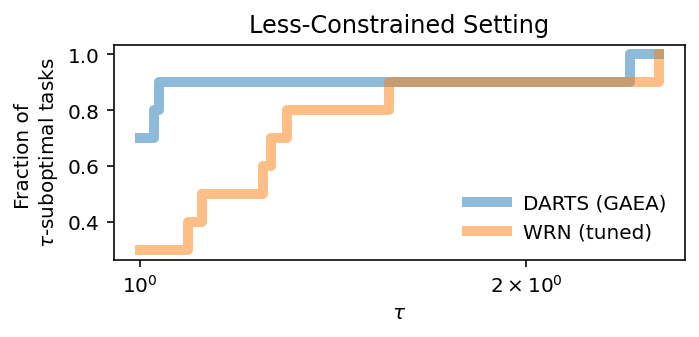

In [7]:
slow_df.iloc[17]['obj'] = 34.7
slow_df.iloc[19]['obj'] = 36.4
slow_df.iloc[12]['obj']=17.7
slow_df.iloc[0]['obj']=23.39
slow_taus, slow_solver_vals, slow_solvers, slow_transformed_data = calc_perprof(slow_df, ['problem'], ['obj'], ['method'])


def draw_slow_pp(taus, solver_vals, solvers):
    
    fig = plt.figure(figsize=(5.0, 2.5))
    ax = fig.add_subplot(111)
    
    # Add lines individually to support labels
    for n, solver in enumerate(solvers):
        if solver == 'GAEA PC-DARTS':
            solver = 'DARTS (GAEA)'
        else:
            solver = 'WRN (tuned)'
        ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)
        
    plt.legend(frameon=False)
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('Fraction of \n' + r'$\tau$-suboptimal tasks')
    #ax.yaxis.label.set_size(18)
    #ax.xaxis.label.set_size(18)

    ax.set_xscale('log')
    #plt.xlim(1,2.6)
    plt.xticks([1e0, 2e0])
    ax.set_title('Less-Constrained Setting')
    #ax.title.set_size(20)
    ax.tick_params(axis='both', which='minor')
    plt.minorticks_off()

    #ax.set_xticks([0,1,2])
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.get_xaxis().get_major_formatter().labelOnlyBase = False

    
    plt.tight_layout()
    plt.savefig('pp_slow.pdf')

draw_slow_pp(slow_taus, slow_solver_vals, slow_solvers)


Number of problems per solver:  10


/tmp/ipykernel_1669375/3958465297.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)


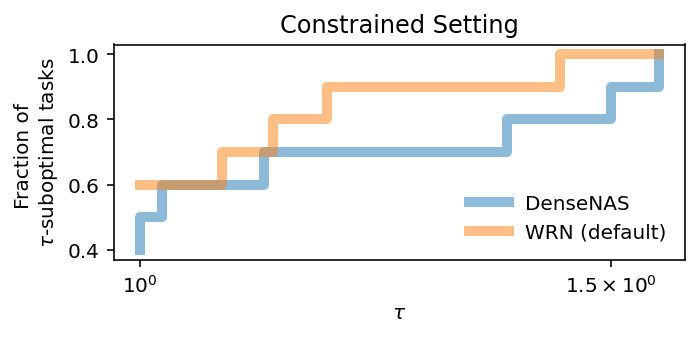

In [8]:
fast_df_small = fast_df[fast_df['method']!='DenseNAS-RS']
fast_taus, fast_solver_vals, fast_solvers, fast_transformed_data = calc_perprof(fast_df_small, ['problem'], ['obj'], ['method'])


def draw_fast_pp(taus, solver_vals, solvers):
    
    fig = plt.figure(figsize=(5.0, 2.5))
    ax = fig.add_subplot(111)
    
    # Add lines individually to support labels
    for n, solver in enumerate(solvers):
        if solver == 'WRN':
            solver = 'WRN (default)'

        ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)
        
    plt.legend(frameon=False)
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('Fraction of \n' + r'$\tau$-suboptimal tasks')
    #ax.yaxis.label.set_size(18)
    #ax.xaxis.label.set_size(18)

    ax.set_xscale('log')
    
    #plt.xlim(1,1.6)
    plt.xticks([1e0, 1.5e0])
    ax.set_title('Constrained Setting')
    #ax.title.set_size(20)
    ax.tick_params(axis='both', which='minor')
    plt.minorticks_off()

    #ax.set_xticks([0,1,2])
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.get_xaxis().get_major_formatter().labelOnlyBase = False

    
    plt.tight_layout()
    plt.savefig('pp_fast.pdf')

draw_fast_pp(fast_taus, fast_solver_vals, fast_solvers)


Number of problems per solver:  10


/tmp/ipykernel_1669375/2351100509.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)


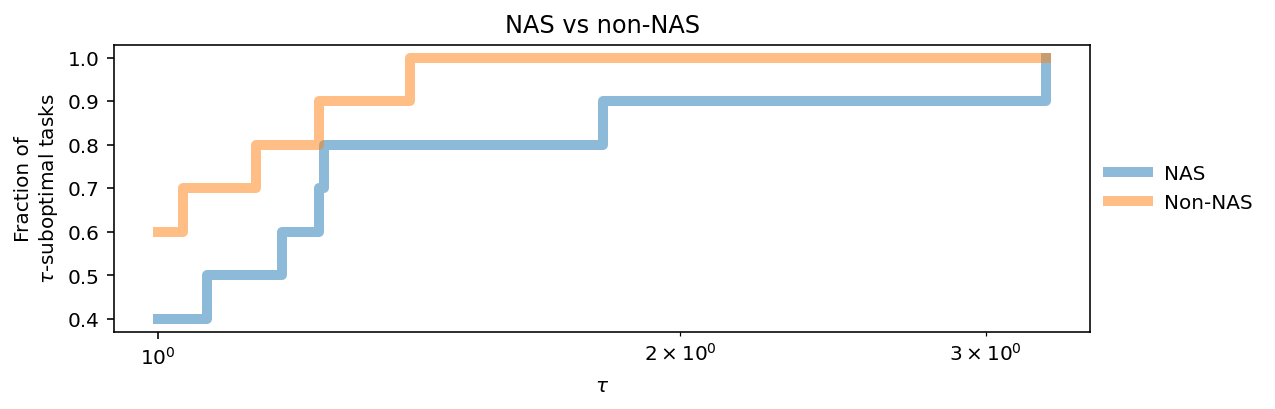

In [9]:
import copy

methods = (['NAS'] * 10) + (['Non-NAS'] * 10)
objectives = [24.02, 48.23, 8.45, 60.0, 2.6, 2.94, 22.9, 33.0, 12.51, 32.0, 
            19.39, 67.41, 6.78, 62.0, 0.8, 3.35, 12.68197067, 28.0, 15.49, 30.0]
nas_df = copy.deepcopy(slow_df)
for i in range(20):
    nas_df.loc[i]['method'] = methods[i]
    nas_df.loc[i]['obj'] = objectives[i]

comb_taus, comb_solver_vals, comb_solvers, comb_transformed_data = calc_perprof(
    nas_df, ['problem'], ['obj'], ['method'])


def draw_nas_pp(taus, solver_vals, solvers):
    
    fig = plt.figure(figsize=(9, 3))
    ax = fig.add_subplot(111)
    
    # Add lines individually to support labels
    for n, solver in enumerate(solvers):
        ax.step(taus.astype(np.float), solver_vals[n, :], label=solver, linewidth=5, where='post', alpha=0.5)
        
    plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('Fraction of\n' r'$\tau$-suboptimal tasks')

    ax.set_xscale('log')
    ax.set_title('NAS vs non-NAS')

    
    plt.tight_layout()
    plt.savefig('pp_nas.pdf')
    
draw_nas_pp(comb_taus, comb_solver_vals, comb_solvers)

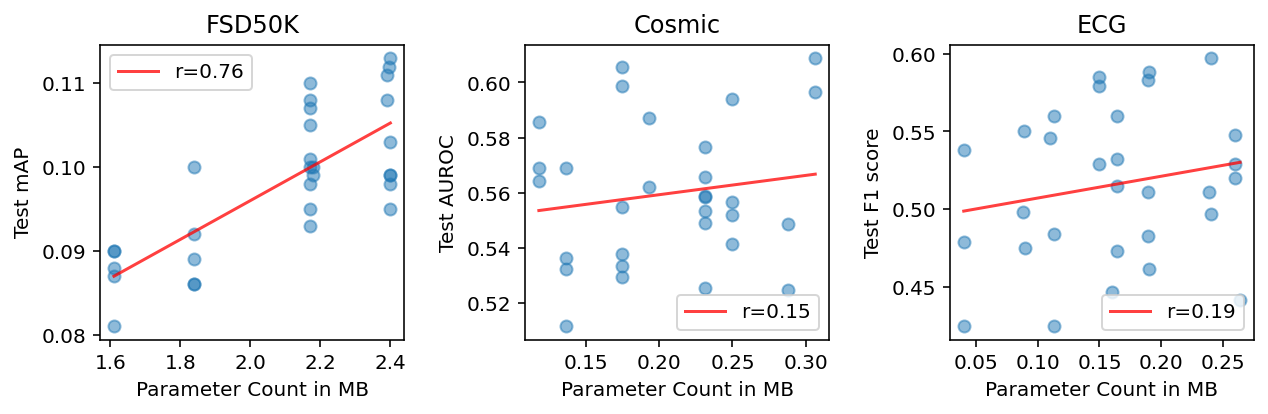

In [14]:
def plot_corr(x, y, title='', xlabel='', ylabel='', ax=None):
    if ax is None:
        ax = plt
    r, _ = stats.pearsonr(x, y)
    # plot the data
    ax.scatter(x, y, alpha=0.5)
    # fits the best fitting line to the data
    ax.plot(np.unique(x), 
            np.poly1d(np.polyfit(x, y, 1))
            (np.unique(x)), color='red', alpha=0.75, label=f'r={r:0.2f}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(frameon=True)

# FSD50k metrics
fsd_metrics = [0.113, 0.112, 0.110, 0.111, 0.107, 0.108, 0.105, 0.098, 0.103, 0.100, 0.108, 0.099, 0.095, 0.100, 0.100, 0.09, 0.087, 0.099, 0.101, 0.095, 0.090, 0.089, 0.093, 0.098, 0.092, 0.088, 0.086, 0.086, 0.099, 0.081]
fsd_size = [2.40, 2.397, 2.17, 2.391, 2.17, 2.17, 2.171, 2.171, 2.40, 2.17, 2.39, 2.18, 2.40, 2.18, 1.84, 1.61, 1.61, 2.40, 2.17, 2.17, 1.61, 1.84, 2.17, 2.40, 1.84, 1.61, 1.84, 1.84, 2.40, 1.61]

# Cosmic metrics
cosmic_old_metrics = [0.20, 0.157, 0.170, 0.154, 0.22, 0.195, 0.108, 0.170, 0.069, 0.161, 0.017, 0.073, 0.038, 0.154, 0.130, 0.105,
      0.06, 0.086, 0.10, 0.02, 0.015, 0.057, 0.084, 0.141,0.05, 0.068, 0.073, 0.084, 0.047, 0.102]
cosmic_old_size = [0.23, 0.136, 0.193, 0.19, 0.34, 0.231, 0.17, 0.19, 0.306, 0.12, 0.136, 0.288, 0.14, 0.193, 0.118, 0.175,
     0.08, 0.193, 0.25, 0.31, 0.193, 0.137, 0.288, 0.175, 0.23, 0.306, 0.288, 0.288, 0.174, 0.288]


cosmic_metrics = [
    0.4234912994366814,0.4058082624242966,0.40143865281254254,0.4704249757035721,0.39425507499708723,0.4416158886930799,0.46211356080447097,0.4465796507906583,0.4511921762362022,0.4410439277672177,
    0.4883935039272532,0.4128960697349031,0.4341406820394367,0.43568409730289015,0.3911887180537533,0.4034021065631508,0.45089209776077854,0.4743578470129671,0.4308896303514085,0.4450284402244422,
    0.4635839024769255,0.45852617053407463,0.4310870797796842,0.414329294767678,0.44796857019224146,0.4752732689317748,0.46759148158455976,0.4378874918065958,0.4667062252581087,0.4433970213793539,
]
cosmic_metrics = np.array(cosmic_metrics)
cosmic_metrics = 1.0 - cosmic_metrics

cosmic_size = [
    0.231257,0.249817,0.174585,0.174585,0.174585,0.231257,0.174585,0.231257,0.287929,0.231257,
    0.136473,0.193145,0.231257,0.117913,0.306489,0.306489,0.231257,0.231257,0.117913,0.174585,
    0.136473,0.249817,0.136473,0.117913,0.249817,0.287929,0.136473,0.193145,0.174585,0.249817
]



# ECG metrics
ecg_metrics= [0.597,0.588, 0.585, 0.583, 0.579, 0.520, 0.560, 0.550, 0.546, 0.560, 0.548, 0.425, 0.447, 0.462, 0.425, 0.442,
       0.473, 0.475, 0.479, 0.483, 0.484, 0.532, 0.538, 0.515, 0.511, 0.498, 0.497, 0.529, 0.529, 0.511]
ecg_size = [0.24, 0.19, 0.15, 0.189, 0.15, 0.26, 0.113, 0.089, 0.11, 0.164, 0.26, 0.113, 0.16, 0.19, 0.04, 0.264,
        0.164, 0.09, 0.04, 0.189, 0.113, 0.164, 0.04, 0.164, 0.189, 0.088, 0.240, 0.15, 0.26, 0.239]

fig, axs = plt.subplots(1, 3, figsize=(3.0*3, 3.0))
plot_corr(fsd_size, fsd_metrics, 
    title='FSD50K', 
    xlabel='Parameter Count in MB',
    ylabel='Test mAP',
    ax=axs[0])

plot_corr(cosmic_size, cosmic_metrics, 
    title='Cosmic', 
    xlabel='Parameter Count in MB',
    ylabel=r'Test AUROC',
    ax=axs[1])

plot_corr(ecg_size, ecg_metrics, 
    title='ECG', 
    xlabel='Parameter Count in MB',
    ylabel='Test F1 score',
    ax=axs[2])

plt.tight_layout()
plt.savefig('perf_modelsize.pdf')